# 基于U型语义分割模型实现的宠物图像分割

NOTE: 本示例教程依然在开发中，目前是基于2.0alpha版本的Paddle，未来会迁移到2.0beta版本。

## 1.简要介绍

在计算机视觉领域，图像分割指的是将数字图像细分为多个图像子区域的过程。图像分割的目的是简化或改变图像的表示形式，使得图像更容易理解和分析。图像分割通常用于定位图像中的物体和边界（线，曲线等）。更精确的，图像分割是对图像中的每个像素加标签的一个过程，这一过程使得具有相同标签的像素具有某种共同视觉特性。图像分割的领域非常多，无人车、地块检测、表计识别等等。

本示例简要介绍如何通过飞桨开源框架，实现图像分割。这里我们是采用了一个在图像分割领域比较熟知的U-Net网络结构，是一个基于FCN做改进后的一个深度学习网络，包含下采样（编码器，特征提取）和上采样（解码器，分辨率还原）两个阶段，因模型结构比较像U型而命名为U-Net。

## 2.环境设置

本示例基于飞桨开源框架2.0版本。

In [2]:
import os
import paddle
import numpy as np
import matplotlib.pyplot as plt

paddle.__version__

'2.0.0-alpha0'

## 3.数据集

### 3.1 数据集下载

本案例使用Oxford-IIIT Pet数据集，官网：https://www.robots.ox.ac.uk/~vgg/data/pets 。

数据集统计如下：

![alt 数据集统计信息](https://www.robots.ox.ac.uk/~vgg/data/pets/breed_count.jpg)

数据集包含两个压缩文件：

1. 原图：https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
2. 分割图像：https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [5]:
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

% Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  1148k      0  0:11:13  0:11:13 --:--:--  780k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0   893k      0  0:00:20  0:00:20 --:--:-- 1847k


### 3.2 数据集整理

首先我们先看看下载到磁盘上的文件结构是什么样的。首先看images.tar.gz，该文件解压后得到一个images目录，这个目录比较简单，里面直接放的是用类名和序号命名好的图片文件。然后我们在看下annotations.tar.gz文件解压后的目录，里面包含以下内容，我们可以通过README文件查看每个目录的说明介绍。
```bash
.
├── README
├── list.txt
├── test.txt
├── trainval.txt
├── trimaps
└── xmls
```
这次我们主要使用到images目录和annotations/trimaps目录，即原图文件和分割图像文件。

由于所有文件都是散落在文件夹中，在训练时我们需要使用的是数据集和标签对应的数据关系，所以我们第一步是对原始的数据集进行整理，得到数据集和标签两个数组，分别一一对应。这样可以在使用的时候能够很方便的找到原始数据和标签的对应关系，否则对于原有的文件夹图片数据无法直接应用。

在这里是用了一个非常简单的方法，按照文件名称进行排序。因为刚好数据和标签的文件名是按照这个逻辑制作的，名字都一样，只有扩展名不一样。

In [3]:
input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 4
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


### 3.3 数据集抽样展示

数据关系整理好之后我们来抽样检查下是否符合我们的预期。我们取出想要抽样查看的图片文件路径，然后通过matplotlib进行图像展示，这里要注意的是对于分割的标签文件因为是1通道的灰度图片，需要在使用imshow接口时注意下传参cmap='gray'。

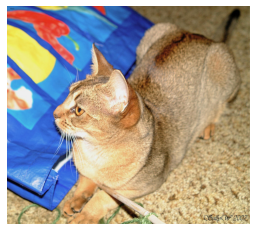

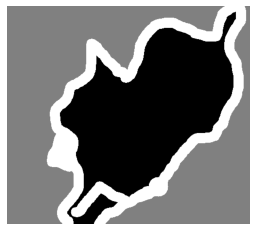

In [4]:
from PIL import Image as PilImage

def show_image(image, cmap=None):
    plt.figure()

    if cmap is None:
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=cmap)
        
    plt.axis('off')
    plt.show()


show_image(PilImage.open(input_img_paths[9]))
show_image(PilImage.open(target_img_paths[9]), 'gray')

### 3.4 数据集Class定义

PaddlePaddle数据集方案是使用Dataset（数据集定义）+DataLoader（数据集加载），那么在整理好数据集和标签对应关系后，我们继续准备框架训练使用的数据集Class，继承paddle.io.Dataset进行数据集子类定义。

继承父类实现以下两个方法：

```python
    # 每次迭代时返回数据和对应的标签
    def __getitem__(self, idx):
        return x, y

    # 返回整个数据集的数目
    def __len__(self):
        return count(samples)
```

在数据集内部可以结合图像数据预处理相关API进行图像的预处理（改变大小、反转、调整格式等）。

由于加载进来的图像不一定都符合自己的需求，举个例子，已下载的这些图片里面就会有RGBA格式的图片，这个时候图片就不符合我们所需3通道的需求，我们需要进行图片的格式转换，那么这里我们直接实现了一个通用的图片读取接口，确保读取出来的图片都是满足我们的需求。

另外图片加载出来的默认shape是HWC，这个时候要看看是否满足后面训练的需要，如果Layer的默认格式和这个不是符合的情况下，需要看下Layer有没有参数可以进行格式调整。不过如果layer较多的话，还是直接调整原数据Shape比较好，否则每个layer都要做参数设置，如果有遗漏就会导致训练出错，那么在本案例中是直接对数据源的shape做了统一调整，从HWC转换成了CHW，因为飞桨的卷积等API的默认输入格式为CHW，这样处理方便后续模型训练。

In [5]:
import paddle
import numpy as np
import io

from paddle.incubate import hapi
from paddle.io import Dataset
from paddle.incubate.hapi.vision.transforms import transforms


def load_img(path, image_size=None, color_mode='rgb'):
    """
    统一的图像处理接口封装，用于规整图像大小和通道
    """
    with open(path, 'rb') as f:
        img = PilImage.open(io.BytesIO(f.read()))
        if color_mode == 'grayscale':
            # if image is not already an 8-bit, 16-bit or 32-bit grayscale image
            # convert it to an 8-bit grayscale image.
            if img.mode not in ('L', 'I;16', 'I'):
                img = img.convert('L')
        elif color_mode == 'rgba':
            if img.mode != 'RGBA':
                img = img.convert('RGBA')
        elif color_mode == 'rgb':
            if img.mode != 'RGB':
                img = img.convert('RGB')
        else:
            raise ValueError('color_mode must be "grayscale", "rgb", or "rgba"')

        if image_size is not None:
            if img.size != image_size:
                img = img.resize(image_size, PilImage.NEAREST)

        return img


class ImgTranspose(object):
    """
    图像预处理工具，用于将Mask图像进行升维(160, 160) => (160, 160, 1)，
    并对图像的维度进行转换从HWC变为CHW
    """
    def __init__(self, fmt):
        self.format = fmt
        
    def __call__(self, img):
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=2)
            
        return img.transpose(self.format)

class PetDataSet(Dataset):
    """
    数据集定义
    """
    def __init__(self, image_size, input_img_paths, target_img_paths):
        self.image_size = image_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        
        self.transforms = transforms.Compose([
            ImgTranspose((2, 0, 1))
        ])

    def __getitem__(self, idx):
        """
        返回 image, label
        """
        # 花了比较多的时间在数据处理这里，需要处理成模型能适配的格式，踩了一些坑（比如有不是RGB格式的）
        # 有图片会出现通道数和期望不符的情况，需要进行相关考虑

        # 图片的路径信息
        input_img_path = self.input_img_paths[idx]

        # 用PIL的Image来读取图像文件，并经过numpy转换为数组
        # img_x = Image.open(input_img_path)
        img_x = load_img(input_img_path, self.image_size)
        x = np.array(img_x, dtype='float32')

        # 对图像进行预处理，统一大小，转换维度格式（HWC => CHW）
        x = self.transforms(x)
        # print(input_img_path)
        # print(x.shape)
        
        # Label图像路径
        target_img_path = self.target_img_paths[idx]  

        # 加载图像
        img_y = load_img(target_img_path, self.image_size, color_mode="grayscale")  
        y = np.array(img_y, dtype='uint8')  

        # 图像预处理
        # Label图像是二维的数组(size, size)，升维到(size, size, 1)后才能用于最后loss计算
        y = self.transforms(y)
        
        # 返回img, label，转换为需要的格式
        return x, y.astype('int64')
        
    def __len__(self):
        return len(self.target_img_paths)

### 3.5 PetDataSet抽样展示

实现好Dataset数据集后，我们来测试一下数据集是否符合预期，因为Dataset是一个可以被迭代的Class，我们通过for循环从里面读取数据来用matplotlib进行展示。

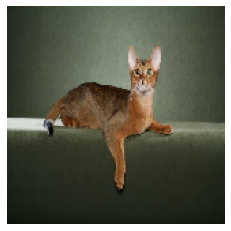

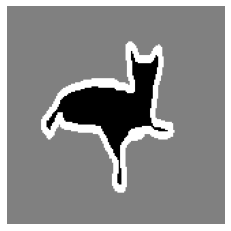

In [6]:
import matplotlib.pyplot as plt


for i in PetDataSet((160, 160), input_img_paths, target_img_paths):
    # 原图
    plt.figure()
    plt.imshow(i[0].transpose((1, 2, 0)).astype('uint8'))
    plt.axis("off")
    plt.show()

    # Mask
    plt.figure()
    plt.imshow(np.squeeze(i[1], axis=0).astype('uint8'), cmap='gray')
    plt.axis("off")
    plt.show()
    break

## 4.模型组网

U-Net是一个U型网络结构，可以看做两个大的阶段，图像先经过Encoder编码器进行下采样得到高级语义特征图，再经过Decoder解码器上采样将特征图恢复到原图片的分辨率。

### 4.1 自定义模型可视化工具类

因为目前Hapi中没有对应Keras的summary接口，无法展示网络结构和每层的输入输出结构信息，所以自定义了一个工具类来实现网络结构可视化。

@TODO，替换为summary接口调用


In [7]:
import paddle

from tabulate import tabulate

from paddle.incubate.hapi.model import Model
from paddle import nn
from paddle.nn import Layer, Sequential
from paddle.incubate.hapi.model import Input


class ModelTools(object):
    def __init__(self):
        self.debug_table_data = []
        self.param_total_count = 0
        
    def _get_param_info(self, layer):
        total_count = 0
        
        for param in layer.parameters():
            item_size = 1

            for axis_len in param.shape:
                item_size *= axis_len

            total_count += item_size

        return total_count

    def write_log(self, layer, in_shape, out_shape):
        if type(layer) is not str:
            layer_name = layer.full_name()
            param_count = self._get_param_info(layer)
        else:
            layer_name = layer
            param_count = 0
        
        self.param_total_count += param_count
        self.debug_table_data.append([layer_name, in_shape, out_shape, param_count])

    def invoke(self, layer, inputs, inputs_2=None, layer_name=None):
        if inputs_2 is not None:
            in_shape = '{} + {}'.format(inputs.shape, inputs_2.shape)
            output = layer(inputs, inputs_2)
        else:
            in_shape = inputs.shape
            output = layer(inputs)

        layer_name = layer_name if layer_name is not None else layer
        self.write_log(layer_name, in_shape, output.shape)

        return output
    
    def show(self):
        print(tabulate(self.debug_table_data, headers=['Layer', 'In Shape', 'Out Shape', 'Param Num'], tablefmt='pretty'))
        print('Total Params: {}'.format(self.param_total_count))

### 4.2 自定义SeparableConv2D接口

这里我们是继承paddle.nn.Layer自定义了一个SeparableConv2D Layer类，整个过程是把`filter_size * filter_size * num_filters`的Conv2D操作拆解为两个子Conv2D，先对输入数据的每个通道使用`filter_size * filter_size * 1`的卷积核进行计算，输入输出通道数目相同，之后在使用`1 * 1 * num_filters`的卷积核计算，减少卷积操作中的训练参数，提升性能。

In [8]:
class SeparableConv2D(Layer):
    def __init__(self, 
                 num_channels, 
                 num_filters, 
                 filter_size, 
                 padding=0, 
                 stride=1, 
                 dilation=1, 
                 groups=None, 
                 param_attr=None, 
                 bias_attr=None, 
                 use_cudnn=True, 
                 act=None, 
                 data_format="NCHW", 
                 dtype="float32"):
        super(SeparableConv2D, self).__init__()
        # 第一次卷积操作没有偏置参数
        self.conv_1 = nn.Conv2D(num_channels, 
                             num_channels, 
                             filter_size, 
                             padding=padding,
                             stride=stride,
                             dilation=dilation,
                             groups=num_channels, 
                             param_attr=param_attr, 
                             bias_attr=False, 
                             use_cudnn=use_cudnn, 
                             act=None, 
                             data_format=data_format, 
                             dtype=dtype)
        self.pointwise = nn.Conv2D(num_channels, 
                             num_filters, 
                             1, 
                             padding=0, 
                             stride=1, 
                             dilation=1, 
                             groups=1, 
                             bias_attr=bias_attr, 
                             use_cudnn=use_cudnn, 
                             act=act, 
                             data_format=data_format, 
                             dtype=dtype)
        
    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.pointwise(x)

        return x

### 4.3 自定义Encoder编码器Layer

我们将网络结构中的Encoder下采样过程进行了一个自定义Layer封装，方便后续调用，减少代码编写，下采样是有一个模型逐渐向下画曲线的一个过程，这个过程中是不断的重复一个单元结构将通道数不断增加，形状不断缩小，并且引入残差网络结构，我们将这些都抽象出来进行统一封装。


In [9]:
class Encoder(Layer):
    def __init__(self, num_channels, filters, tools):
        super(Encoder, self).__init__()
        self.tools = tools
        self.relu = nn.ReLU()
        self.separable_conv_01 = SeparableConv2D(num_channels, filters, 3, padding='SAME')
        self.bn = nn.BatchNorm(filters)
        self.separable_conv_02 = SeparableConv2D(filters, filters, 3, padding='SAME')
        self.pool = nn.Pool2D(pool_size=3, pool_type='max', pool_stride=2, pool_padding=1) 
        self.residual_conv = nn.Conv2D(num_channels, filters, 1, stride=2, padding='SAME')

    def forward(self, inputs):
        previous_block_activation = inputs

        x = self.tools.invoke(self.relu, inputs)
        x = self.tools.invoke(self.separable_conv_01, x)
        x = self.tools.invoke(self.bn, x)
        x = self.tools.invoke(self.relu, x)
        x = self.tools.invoke(self.separable_conv_02, x)
        x = self.tools.invoke(self.bn, x)
        x = self.tools.invoke(self.pool, x)
        residual = self.tools.invoke(self.residual_conv, previous_block_activation)
        x = self.tools.invoke(paddle.add, x, inputs_2=residual, layer_name='ADD')

        return x

### 4.4 自定义Decoder解码器Layer

在通道数达到最大得到高级语义特征图后，网络结构会开始进行decode操作，进行上采样，通道数逐渐减小，对应图片尺寸逐步增加，直至恢复到原图像大小，那么这个过程里面也是通过不断的重复相同结构的残差网络完成，我们也是为了减少代码编写，将这个过程定义一个Layer来放到模型组网中使用。

In [10]:
class Decoder(Layer):
    def __init__(self, num_channels, num_filters, tools):
        super(Decoder, self).__init__()
        self.tools = tools

        self.relu = nn.ReLU()
        self.conv_transpose_01 = nn.Conv2DTranspose(num_channels, num_filters, 3, padding='SAME')
        self.conv_transpose_02 = nn.Conv2DTranspose(num_filters, num_filters, 3, padding='SAME')
        self.bn = nn.BatchNorm(num_filters)
        self.upsample = nn.UpSample(scale=2.0)
        self.residual_conv = nn.Conv2D(num_channels, num_filters, 1, padding='SAME')

    def forward(self, inputs):
        previous_block_activation = inputs

        x = self.tools.invoke(self.relu, inputs)
        x = self.tools.invoke(self.conv_transpose_01, x)
        x = self.tools.invoke(self.bn, x)
        x = self.tools.invoke(self.relu, x)
        x = self.tools.invoke(self.conv_transpose_02, x)
        x = self.tools.invoke(self.bn, x)
        x = self.tools.invoke(self.upsample, x)
        residual = self.tools.invoke(self.upsample, previous_block_activation)
        residual = self.tools.invoke(self.residual_conv, residual)
        x = self.tools.invoke(paddle.add, x, inputs_2=residual, layer_name='ADD')
        
        return x

### 4.5 训练模型组网

按照U型网络结构格式进行整体的网络结构搭建，三次下采样，四次上采样。

In [18]:
class PetModel(Model):
    def __init__(self, num_classes, tools):
        super(PetModel, self).__init__()
        self.tools = tools

        self.conv_1 = nn.Conv2D(3, 32, 3, padding='SAME', stride=2)
        self.bn = nn.BatchNorm(32)
        self.relu = nn.ReLU()

        num_channels = 32
        self.encoders = []
        self.encoder_list = [64, 128, 256]
        self.decoder_list = [256, 128, 64, 32]

        # 根据下采样个数和配置循环定义子Layer，避免重复写一样的程序
        for num_filters in self.encoder_list:
            block = self.add_sublayer('encoder_%s'.format(num_filters),
                                      Encoder(num_channels, num_filters, self.tools))
            self.encoders.append(block)
            num_channels = num_filters

        self.decoders = []

        # 根据上采样个数和配置循环定义子Layer，避免重复写一样的程序
        for num_filters in self.decoder_list:
            block = self.add_sublayer('decoder_%s'.format(num_filters), 
                                      Decoder(num_channels, num_filters, self.tools))
            self.decoders.append(block)
            num_channels = num_filters

        self.output_conv = nn.Conv2D(num_channels, num_classes, 3, padding='SAME')
    
    def forward(self, inputs):
        y = self.tools.invoke(self.conv_1, inputs)
        y = self.tools.invoke(self.bn, y)
        y = self.tools.invoke(self.relu, y)
        
        for encoder in self.encoders:
            y = encoder(y)

        for decoder in self.decoders:
            y = decoder(y)
        
        y = self.tools.invoke(self.output_conv, y)
        
        return y

### 4.6 模型可视化

调用飞桨提供的summary接口对组建好的模型进行可视化，方便进行模型结构和参数信息的查看和确认。
@TODO，需要替换

In [19]:
img_size = (160, 160)
num_classes = 4
model_tools = ModelTools()

with paddle.imperative.guard():
    model = PetModel(num_classes, model_tools)

    for i in PetDataSet((160, 160), input_img_paths, target_img_paths):
        data = paddle.imperative.to_variable(np.expand_dims(i[0].astype('float32'), 0))
        res = model(data)
        break

    model_tools.show()

+--------------------+---------------------------------------+-------------------+-----------+
|       Layer        |               In Shape                |     Out Shape     | Param Num |
+--------------------+---------------------------------------+-------------------+-----------+
|      conv2d_0      |           [1, 3, 160, 160]            |  [1, 32, 80, 80]  |    896    |
|    batch_norm_0    |            [1, 32, 80, 80]            |  [1, 32, 80, 80]  |    128    |
|      re_lu_0       |            [1, 32, 80, 80]            |  [1, 32, 80, 80]  |     0     |
|      re_lu_1       |            [1, 32, 80, 80]            |  [1, 32, 80, 80]  |     0     |
| separable_conv2d_0 |            [1, 32, 80, 80]            |  [1, 64, 80, 80]  |   2400    |
|    batch_norm_1    |            [1, 64, 80, 80]            |  [1, 64, 80, 80]  |    256    |
|      re_lu_1       |            [1, 64, 80, 80]            |  [1, 64, 80, 80]  |     0     |
| separable_conv2d_1 |            [1, 64, 80, 80] 

## 5.模型训练

### 5.1 训练数据集生成

将所有的数据集文件进行随机打乱并切分，划分为训练数据集和评估数据集，使用之前定义好的PetDataset类进行训练和评估数据集的实例化，以便后续在fit接口中直接使用。

In [13]:
import random


# 进行随机打乱和切分数据集，这个部分根据自己的实际任务需要完成即可，非框架标准内容
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# 使用切分好的数据进行数据集的实例化
train_dataset = PetDataSet(img_size, train_input_img_paths, train_target_img_paths)
val_dataset = PetDataSet(img_size, val_input_img_paths, val_target_img_paths)

### 5.2 配置信息

定义训练BATCH_SIZE、训练轮次和计算设备等信息。

In [22]:
from paddle.optimizer import RMSPropOptimizer
from paddle.incubate.hapi.callbacks import Callback
from paddle.incubate.hapi.metrics import Metric
from paddle.incubate.hapi.model import set_device
from paddle.incubate.hapi.loss import Loss
import paddle.fluid as fluid

BATCH_SIZE = 32
EPOCHS = 15
dynamic = True
device = set_device('gpu')
paddle.enable_imperative(device) if dynamic else None

### 5.3 自定义Loss

@TODO，替换成Beta中统一的Loss API，不需要自定义了。

In [23]:
class SoftmaxWithCrossEntropy(Loss):
    def __init__(self, average=True):
        super(SoftmaxWithCrossEntropy, self).__init__(average)

    def forward(self, outputs, labels):
        return [
            fluid.layers.softmax_with_cross_entropy(
                o, l, return_softmax=False, axis=1) for o, l in zip(outputs, labels)
        ]

### 5.4 自定义Metric

Paddle里面有一个functional形式的mean_iou接口，我们需要使用一个Class形式的API，这里我们来自定义实现一个。

In [31]:
class MIOUMetric(Metric):
    def __init__(self, num_classes, name=None, *args, **kwargs):
        super(MIOUMetric, self).__init__(*args, **kwargs)
        self.num_classes = num_classes
        self._name = name or 'miou'
        self.reset()
    
    def add_metric_op(self, output, label):
        return paddle.metric.mean_iou(output.astype('int64'), label, self.num_classes)

    def update(self, mean_iou, out_wrong, out_correct, *args):
        print(out_correct)
        exit()
        return mean_iou

    def reset(self):
        # do nothing
        self.total = [0.]
        self.count = [0]

    def accumulate(self):
        res = []
        for t, c in zip(self.total, self.count):
            res.append(float(t) / c)

        return res

    def name(self):
        return self._name

### 5.5 启动模型训练

使用模型代码进行Model实例生成，使用prepare接口定义优化器、损失函数和评价指标等信息，用于后续训练使用。在所有初步配置完成后，调用fit接口开启训练执行过程，调用fit时只需要将前面定义好的训练数据集、测试数据集、训练轮次（Epoch）和批次大小（batch_size）配置好即可。

In [ ]:
optim = RMSPropOptimizer(learning_rate=0.001, 
                         rho=0.9, 
                         momentum=0.0, 
                         epsilon=1e-07, 
                         centered=False,
                         parameter_list=model.parameters())
model.prepare(optim, 
    SoftmaxWithCrossEntropy(),
    MIOUMetric(num_classes),
    [Input([None, 3, 160, 160], 'float32', name='image')],
    [Input([None, 1, 160, 160], 'int64', name='label')],
    device=device
)

model.fit(train_dataset, 
    val_dataset, 
    epochs=1, 
    batch_size=32
)

Epoch 1/1


## 6.模型预测

### 6.1 预测数据集准备和预测

继续使用PetDataset来实例化待预测使用的数据集。这里我们为了方便没有在另外准备预测数据，复用了评估数据。

我们可以直接使用model.predict接口来对数据集进行预测操作，只需要将预测数据集传递到接口内即可。

In [ ]:
predict_dataset = PetDataSet(img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(predict_dataset)

### 6.2 预测结果可视化

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
# Display mask predicted by our model
i = 0
mask_idx = 0

for data in PetDataSet(img_size, val_input_img_paths, val_target_img_paths):
    if i > 8: 
        break
    plt.subplot(3, 3, i + 1)
    plt.imshow(data[0].transpose((1, 2, 0)).astype('uint8'))
    plt.title('Input Image')
    plt.axis("off")

    plt.subplot(3, 3, i + 2)
    plt.imshow(np.squeeze(data[1], axis=0).astype('uint8'), cmap='gray')
    plt.title('Label')
    plt.axis("off")
    
    
    data = val_preds[0][mask_idx][0].transpose((1, 2, 0))
    mask = np.argmax(data, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    plt.subplot(3, 3, i + 3)
    plt.imshow(np.squeeze(mask, axis=2).astype('uint8'), cmap='gray')
    plt.title('Predict')
    plt.axis("off")
    i += 3
    mask_idx += 1

plt.show()